# 03 — Statistical Analysis
## The Ship Index: Can shipping costs predict GDP?

This is the core analytical notebook. We test whether the Baltic Dry Index
is a statistically significant **leading indicator** for GDP growth.

**Tests we'll run:**
1. Cross-correlation at 0–4 quarter lags (find the optimal lead time)
2. Granger causality tests (does BDI statistically "predict" GDP?)
3. Regression modelling (baseline vs Ship Index model)
4. The Pentagon Pizza Test (did BDI call each turning point first?)

By the end, we'll have a clear, evidence-based answer to our research question.

---
## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

NAVY = '#0C2340'
BLUE = '#1A5276'
LIGHT_BLUE = '#2E86C1'
RED = '#C0392B'
GREEN = '#1E8449'
GREY = '#7F8C8D'
ORANGE = '#E67E22'
PURPLE = '#8E44AD'

print('All libraries loaded successfully!')

All libraries loaded successfully!


In [2]:
# Load processed data from Phase 2
df = pd.read_csv('../data/processed/analysis_quarterly.csv', index_col='date', parse_dates=True)
print(f'Data loaded: {len(df)} quarters, {df.shape[1]} columns')
print(f'Period: {df.index[0].strftime("%Y-%m")} to {df.index[-1].strftime("%Y-%m")}')

Data loaded: 81 quarters, 13 columns
Period: 2000-01 to 2020-01


---
## 1. Cross-Correlation Analysis

The key question: at what **lag** is the correlation between BDI and GDP strongest?

- Lag 0 = same quarter (contemporaneous)
- Lag 1 = BDI this quarter vs GDP next quarter (1-quarter lead)
- Lag 2 = BDI this quarter vs GDP in 2 quarters (2-quarter lead)

If the strongest correlation is at lag 1 or 2, the BDI is a **leading indicator**.

In [3]:
def cross_correlations(bdi_series, gdp_series, max_lag=4):
    """Calculate correlation between BDI and GDP at different lags.
    Positive lag = BDI leads GDP (what we're looking for).
    """
    results = []
    for lag in range(0, max_lag + 1):
        if lag == 0:
            # Same quarter
            pair = pd.concat([bdi_series, gdp_series], axis=1).dropna()
        else:
            # BDI leads: shift BDI back by 'lag' quarters
            pair = pd.concat([bdi_series.shift(lag), gdp_series], axis=1).dropna()
        
        col_names = pair.columns.tolist()
        corr, p_value = stats.pearsonr(pair[col_names[0]], pair[col_names[1]])
        results.append({
            'lag': lag,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'n_obs': len(pair)
        })
    
    return pd.DataFrame(results)

print('Cross-correlation function defined.')

Cross-correlation function defined.


In [4]:
# Run cross-correlations for all three economies
economies = {
    'UK': 'uk_gdp_growth',
    'US': 'us_gdp_growth',
    'Eurozone': 'eurozone_gdp_growth'
}

all_xcorr = {}
print('CROSS-CORRELATION RESULTS: BDI Mean Growth vs GDP Growth')
print('(Positive lag = BDI leads GDP by N quarters)')
print('='*70)

for name, col in economies.items():
    xcorr = cross_correlations(df['bdi_mean_growth'], df[col], max_lag=4)
    all_xcorr[name] = xcorr
    
    print(f'\n{name}:')
    for _, row in xcorr.iterrows():
        sig = '***' if row['p_value'] < 0.01 else ('**' if row['p_value'] < 0.05 else ('*' if row['p_value'] < 0.1 else '   '))
        print(f'  Lag {int(row["lag"])}: r = {row["correlation"]:+.4f}  (p = {row["p_value"]:.4f}) {sig}  n = {int(row["n_obs"])}')
    
    best = xcorr.loc[xcorr['correlation'].abs().idxmax()]
    print(f'  >>> Strongest correlation at lag {int(best["lag"])}: r = {best["correlation"]:+.4f}')

print('\n*** p < 0.01  ** p < 0.05  * p < 0.10')

CROSS-CORRELATION RESULTS: BDI Mean Growth vs GDP Growth
(Positive lag = BDI leads GDP by N quarters)

UK:
  Lag 0: r = +0.1977  (p = 0.0787) *  n = 80
  Lag 1: r = +0.2323  (p = 0.0394) **  n = 79
  Lag 2: r = -0.0823  (p = 0.4737)      n = 78
  Lag 3: r = +0.0911  (p = 0.4309)      n = 77
  Lag 4: r = +0.1207  (p = 0.2988)      n = 76
  >>> Strongest correlation at lag 1: r = +0.2323

US:
  Lag 0: r = +0.3001  (p = 0.0068) ***  n = 80
  Lag 1: r = +0.1585  (p = 0.1631)      n = 79
  Lag 2: r = -0.0437  (p = 0.7038)      n = 78
  Lag 3: r = +0.0592  (p = 0.6091)      n = 77
  Lag 4: r = +0.0935  (p = 0.4216)      n = 76
  >>> Strongest correlation at lag 0: r = +0.3001

Eurozone:
  Lag 0: r = +0.1087  (p = 0.3372)      n = 80
  Lag 1: r = +0.2849  (p = 0.0109) **  n = 79
  Lag 2: r = -0.0886  (p = 0.4402)      n = 78
  Lag 3: r = -0.0466  (p = 0.6872)      n = 77
  Lag 4: r = +0.1513  (p = 0.1921)      n = 76
  >>> Strongest correlation at lag 1: r = +0.2849

*** p < 0.01  ** p < 0.05

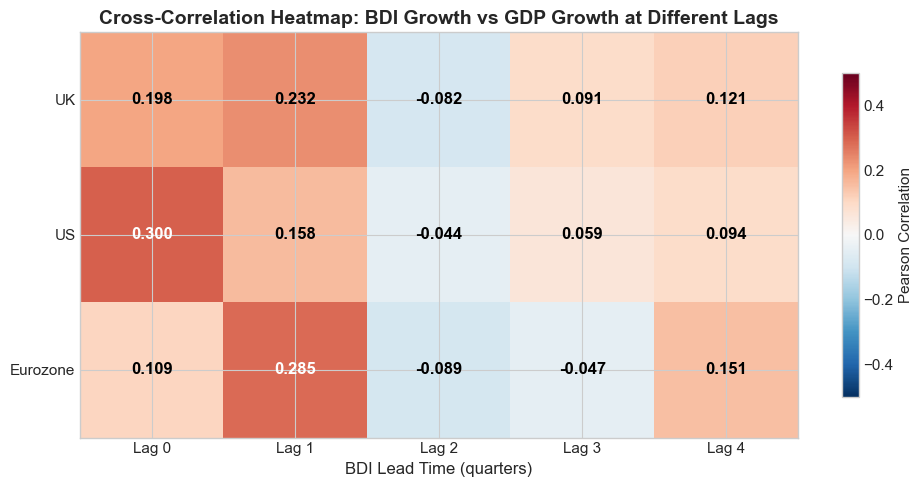


Darker blue = stronger positive correlation at that lag.
Look for which lag shows the deepest blue for each economy.


In [5]:
# Visualise: Cross-correlation heatmap
fig, ax = plt.subplots(figsize=(10, 5))

heatmap_data = pd.DataFrame({
    name: xcorr.set_index('lag')['correlation']
    for name, xcorr in all_xcorr.items()
})

im = ax.imshow(heatmap_data.T.values, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
ax.set_xticks(range(len(heatmap_data)))
ax.set_xticklabels([f'Lag {i}' for i in range(len(heatmap_data))])
ax.set_yticks(range(len(heatmap_data.columns)))
ax.set_yticklabels(heatmap_data.columns)

# Add correlation values as text
for i in range(len(heatmap_data.columns)):
    for j in range(len(heatmap_data)):
        val = heatmap_data.T.values[i, j]
        color = 'white' if abs(val) > 0.25 else 'black'
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', color=color, fontsize=12, fontweight='bold')

plt.colorbar(im, label='Pearson Correlation', shrink=0.8)
ax.set_title('Cross-Correlation Heatmap: BDI Growth vs GDP Growth at Different Lags', fontsize=14, fontweight='bold')
ax.set_xlabel('BDI Lead Time (quarters)', fontsize=12)

plt.tight_layout()
plt.savefig('../outputs/cross_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nDarker blue = stronger positive correlation at that lag.')
print('Look for which lag shows the deepest blue for each economy.')

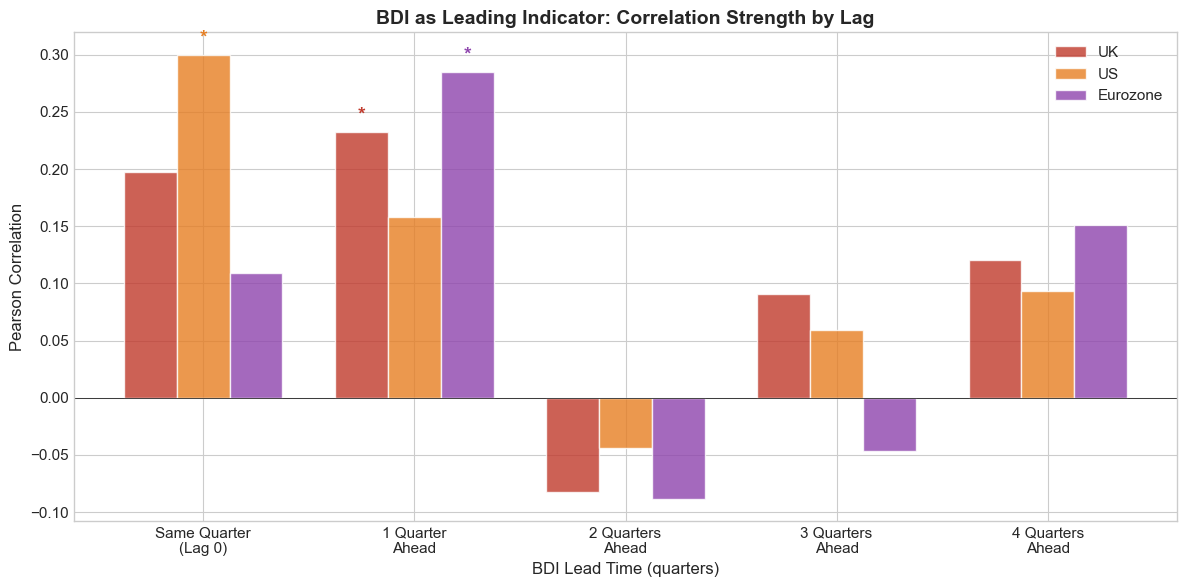

* indicates statistical significance at 95% confidence level


In [6]:
# Visualise: Bar chart of correlations by lag
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.25
lags = range(5)
colors = [RED, ORANGE, PURPLE]

for i, (name, xcorr) in enumerate(all_xcorr.items()):
    offset = (i - 1) * bar_width
    bars = ax.bar([l + offset for l in lags], xcorr['correlation'], bar_width,
                  label=name, color=colors[i], alpha=0.8, edgecolor='white')
    
    # Add significance markers
    for j, (_, row) in enumerate(xcorr.iterrows()):
        if row['p_value'] < 0.05:
            ax.text(j + offset, row['correlation'] + 0.01 * np.sign(row['correlation']),
                   '*', ha='center', fontsize=14, fontweight='bold', color=colors[i])

ax.set_xlabel('BDI Lead Time (quarters)', fontsize=12)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.set_title('BDI as Leading Indicator: Correlation Strength by Lag', fontsize=14, fontweight='bold')
ax.set_xticks(lags)
ax.set_xticklabels(['Same Quarter\n(Lag 0)', '1 Quarter\nAhead', '2 Quarters\nAhead', '3 Quarters\nAhead', '4 Quarters\nAhead'])
ax.axhline(y=0, color='black', linewidth=0.5)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/correlation_by_lag.png', dpi=150, bbox_inches='tight')
plt.show()

print('* indicates statistical significance at 95% confidence level')

---
## 2. Granger Causality Tests

Granger causality tests whether past values of the BDI contain useful information
for predicting future GDP, **beyond what past GDP alone can predict**.

- If p < 0.05: BDI "Granger-causes" GDP (it has predictive power)
- If p >= 0.05: BDI does not add predictive value

We also test the reverse (GDP → BDI) to check directionality.

In [7]:
def run_granger_test(data, cause_col, effect_col, max_lag=4):
    """Run Granger causality test and return results."""
    test_data = data[[effect_col, cause_col]].dropna()
    
    results = []
    try:
        gc_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
        
        for lag in range(1, max_lag + 1):
            f_test = gc_result[lag][0]['ssr_ftest']
            results.append({
                'lag': lag,
                'f_statistic': f_test[0],
                'p_value': f_test[1],
                'significant': f_test[1] < 0.05
            })
    except Exception as e:
        print(f'  Error: {e}')
    
    return pd.DataFrame(results)

print('GRANGER CAUSALITY TEST RESULTS')
print('='*70)

granger_results = {}

for name, col in economies.items():
    print(f'\n--- {name} ---')
    
    # Test: BDI → GDP (does BDI predict GDP?)
    print(f'\n  BDI → {name} GDP (does shipping predict growth?):')
    gc_forward = run_granger_test(df, 'bdi_mean_growth', col, max_lag=4)
    if len(gc_forward) > 0:
        for _, row in gc_forward.iterrows():
            sig = '✓ YES' if row['significant'] else '✗ No'
            print(f'    Lag {int(row["lag"])}: F = {row["f_statistic"]:.3f}, p = {row["p_value"]:.4f}  {sig}')
        granger_results[f'{name}_forward'] = gc_forward
    
    # Test: GDP → BDI (reverse — does GDP predict BDI?)
    print(f'\n  {name} GDP → BDI (reverse causality check):')
    gc_reverse = run_granger_test(df, col, 'bdi_mean_growth', max_lag=4)
    if len(gc_reverse) > 0:
        for _, row in gc_reverse.iterrows():
            sig = '✓ YES' if row['significant'] else '✗ No'
            print(f'    Lag {int(row["lag"])}: F = {row["f_statistic"]:.3f}, p = {row["p_value"]:.4f}  {sig}')
        granger_results[f'{name}_reverse'] = gc_reverse

print('\n' + '='*70)
print('If BDI → GDP is significant but GDP → BDI is not,')
print('we have evidence of one-directional predictive power.')

GRANGER CAUSALITY TEST RESULTS

--- UK ---

  BDI → UK GDP (does shipping predict growth?):
    Lag 1: F = 2.954, p = 0.0897  ✗ No
    Lag 2: F = 4.936, p = 0.0098  ✓ YES
    Lag 3: F = 3.367, p = 0.0233  ✓ YES
    Lag 4: F = 2.586, p = 0.0447  ✓ YES

  UK GDP → BDI (reverse causality check):
    Lag 1: F = 0.187, p = 0.6670  ✗ No
    Lag 2: F = 3.018, p = 0.0550  ✗ No
    Lag 3: F = 2.354, p = 0.0794  ✗ No
    Lag 4: F = 1.894, p = 0.1217  ✗ No

--- US ---

  BDI → US GDP (does shipping predict growth?):
    Lag 1: F = 0.511, p = 0.4768  ✗ No
    Lag 2: F = 0.705, p = 0.4974  ✗ No
    Lag 3: F = 0.516, p = 0.6727  ✗ No
    Lag 4: F = 0.393, p = 0.8133  ✗ No

  US GDP → BDI (reverse causality check):
    Lag 1: F = 0.014, p = 0.9052  ✗ No
    Lag 2: F = 0.360, p = 0.6988  ✗ No
    Lag 3: F = 1.268, p = 0.2922  ✗ No
    Lag 4: F = 1.021, p = 0.4027  ✗ No

--- Eurozone ---

  BDI → Eurozone GDP (does shipping predict growth?):
    Lag 1: F = 8.689, p = 0.0043  ✓ YES
    Lag 2: F = 7.789,

---
## 3. Regression Modelling

Now we build formal models to test whether adding BDI improves GDP predictions.

**Baseline model:** GDP growth this quarter = f(GDP growth last quarter)
- This is a simple autoregressive model — GDP predicting itself.

**Ship Index model:** GDP growth this quarter = f(GDP growth last quarter + BDI change last quarter)
- If R² improves and BDI coefficient is significant, the ocean adds predictive value.

In [8]:
def build_regression_models(data, gdp_col, bdi_col='bdi_mean_growth', lag=1):
    """Build baseline (AR) and Ship Index (AR + BDI) models."""
    
    # Create lagged variables
    model_data = pd.DataFrame({
        'gdp_current': data[gdp_col],
        'gdp_lag': data[gdp_col].shift(lag),
        'bdi_lag': data[bdi_col].shift(lag)
    }).dropna()
    
    y = model_data['gdp_current']
    
    # Baseline: GDP ~ GDP_lag
    X_base = sm.add_constant(model_data[['gdp_lag']])
    baseline = sm.OLS(y, X_base).fit()
    
    # Ship Index: GDP ~ GDP_lag + BDI_lag
    X_ship = sm.add_constant(model_data[['gdp_lag', 'bdi_lag']])
    ship_model = sm.OLS(y, X_ship).fit()
    
    return baseline, ship_model, model_data

print('REGRESSION MODEL COMPARISON')
print('='*70)

regression_results = {}

for name, col in economies.items():
    print(f'\n--- {name} ---')
    
    baseline, ship_model, model_data = build_regression_models(df, col)
    regression_results[name] = {'baseline': baseline, 'ship': ship_model, 'data': model_data}
    
    print(f'\n  Baseline Model (GDP ~ previous GDP):')
    print(f'    R² = {baseline.rsquared:.4f}')
    print(f'    Adj R² = {baseline.rsquared_adj:.4f}')
    print(f'    AIC = {baseline.aic:.1f}')
    
    print(f'\n  Ship Index Model (GDP ~ previous GDP + previous BDI):')
    print(f'    R² = {ship_model.rsquared:.4f}')
    print(f'    Adj R² = {ship_model.rsquared_adj:.4f}')
    print(f'    AIC = {ship_model.aic:.1f}')
    
    # BDI coefficient significance
    bdi_coef = ship_model.params['bdi_lag']
    bdi_pval = ship_model.pvalues['bdi_lag']
    print(f'\n  BDI coefficient: {bdi_coef:.6f} (p = {bdi_pval:.4f})')
    
    r2_improvement = ship_model.rsquared - baseline.rsquared
    print(f'  R² improvement from adding BDI: {r2_improvement:+.4f}')
    
    if bdi_pval < 0.05:
        print(f'  >>> BDI is STATISTICALLY SIGNIFICANT at 95% confidence')
    elif bdi_pval < 0.10:
        print(f'  >>> BDI is marginally significant at 90% confidence')
    else:
        print(f'  >>> BDI is NOT statistically significant')

REGRESSION MODEL COMPARISON

--- UK ---

  Baseline Model (GDP ~ previous GDP):
    R² = 0.4206
    Adj R² = 0.4131
    AIC = 123.8

  Ship Index Model (GDP ~ previous GDP + previous BDI):
    R² = 0.4423
    Adj R² = 0.4276
    AIC = 122.8

  BDI coefficient: 0.003166 (p = 0.0897)
  R² improvement from adding BDI: +0.0217
  >>> BDI is marginally significant at 90% confidence

--- US ---

  Baseline Model (GDP ~ previous GDP):
    R² = 0.1008
    Adj R² = 0.0891
    AIC = 137.9

  Ship Index Model (GDP ~ previous GDP + previous BDI):
    R² = 0.1068
    Adj R² = 0.0833
    AIC = 139.4

  BDI coefficient: 0.001503 (p = 0.4768)
  R² improvement from adding BDI: +0.0060
  >>> BDI is NOT statistically significant

--- Eurozone ---

  Baseline Model (GDP ~ previous GDP):
    R² = 0.2647
    Adj R² = 0.2552
    AIC = 149.3

  Ship Index Model (GDP ~ previous GDP + previous BDI):
    R² = 0.3401
    Adj R² = 0.3228
    AIC = 142.7

  BDI coefficient: 0.006106 (p = 0.0043)
  R² improvement fro

In [9]:
# Show full regression summary for UK (our primary focus)
print('DETAILED REGRESSION: UK Ship Index Model')
print('='*70)
print(regression_results['UK']['ship'].summary())

DETAILED REGRESSION: UK Ship Index Model
                            OLS Regression Results                            
Dep. Variable:            gdp_current   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     30.14
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           2.31e-10
Time:                        16:16:34   Log-Likelihood:                -58.395
No. Observations:                  79   AIC:                             122.8
Df Residuals:                      76   BIC:                             129.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

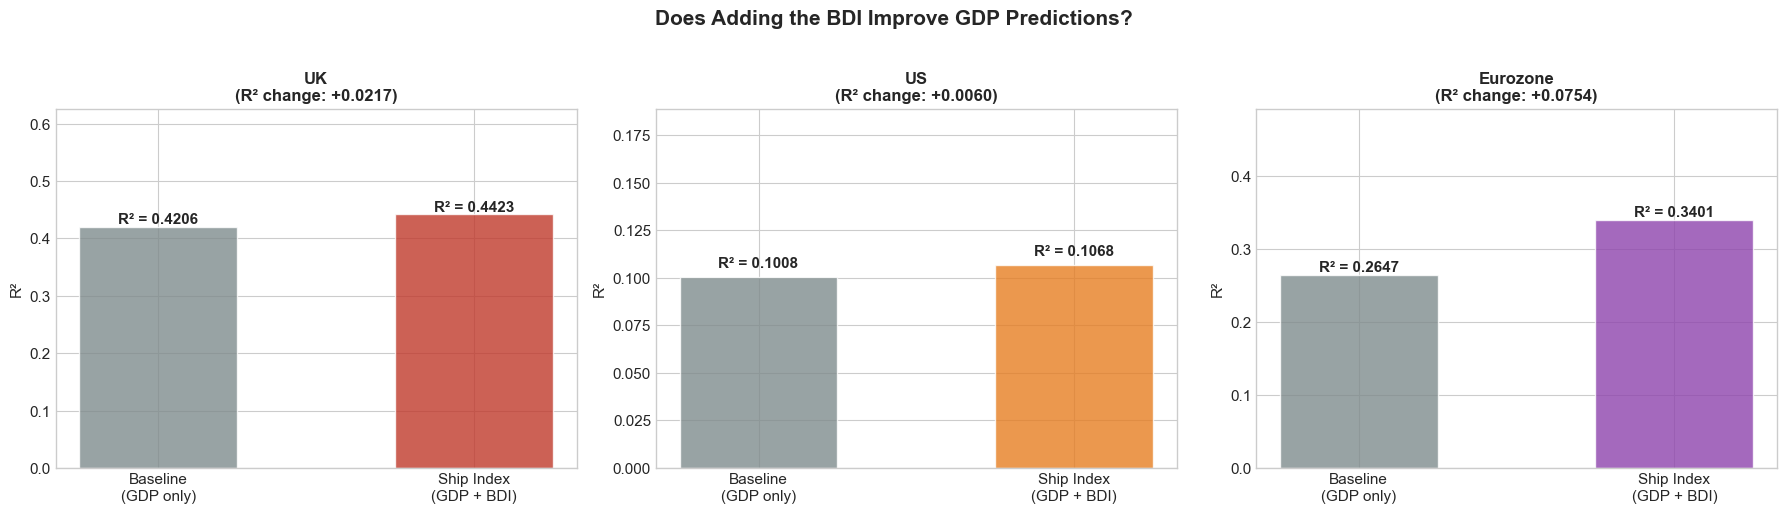

In [11]:
# Visualise: Model comparison chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_econ = [RED, ORANGE, PURPLE]

for ax, (name, res), color in zip(axes, regression_results.items(), colors_econ):
    # Bar chart comparing R² values
    bars = ax.bar(['Baseline\n(GDP only)', 'Ship Index\n(GDP + BDI)'],
                  [res['baseline'].rsquared, res['ship'].rsquared],
                  color=[GREY, color], alpha=0.8, edgecolor='white', width=0.5)
    
    # Add R² labels on bars
    for bar, val in zip(bars, [res['baseline'].rsquared, res['ship'].rsquared]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
               f'R² = {val:.4f}', ha='center', fontsize=11, fontweight='bold')
    
    improvement = res['ship'].rsquared - res['baseline'].rsquared
    ax.set_title(f'{name}\n(R² change: {improvement:+.4f})', fontsize=12, fontweight='bold')
    ax.set_ylabel('R²')
    ax.set_ylim(0, max(res['baseline'].rsquared, res['ship'].rsquared) * 1.3 + 0.05)

plt.suptitle('Does Adding the BDI Improve GDP Predictions?', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

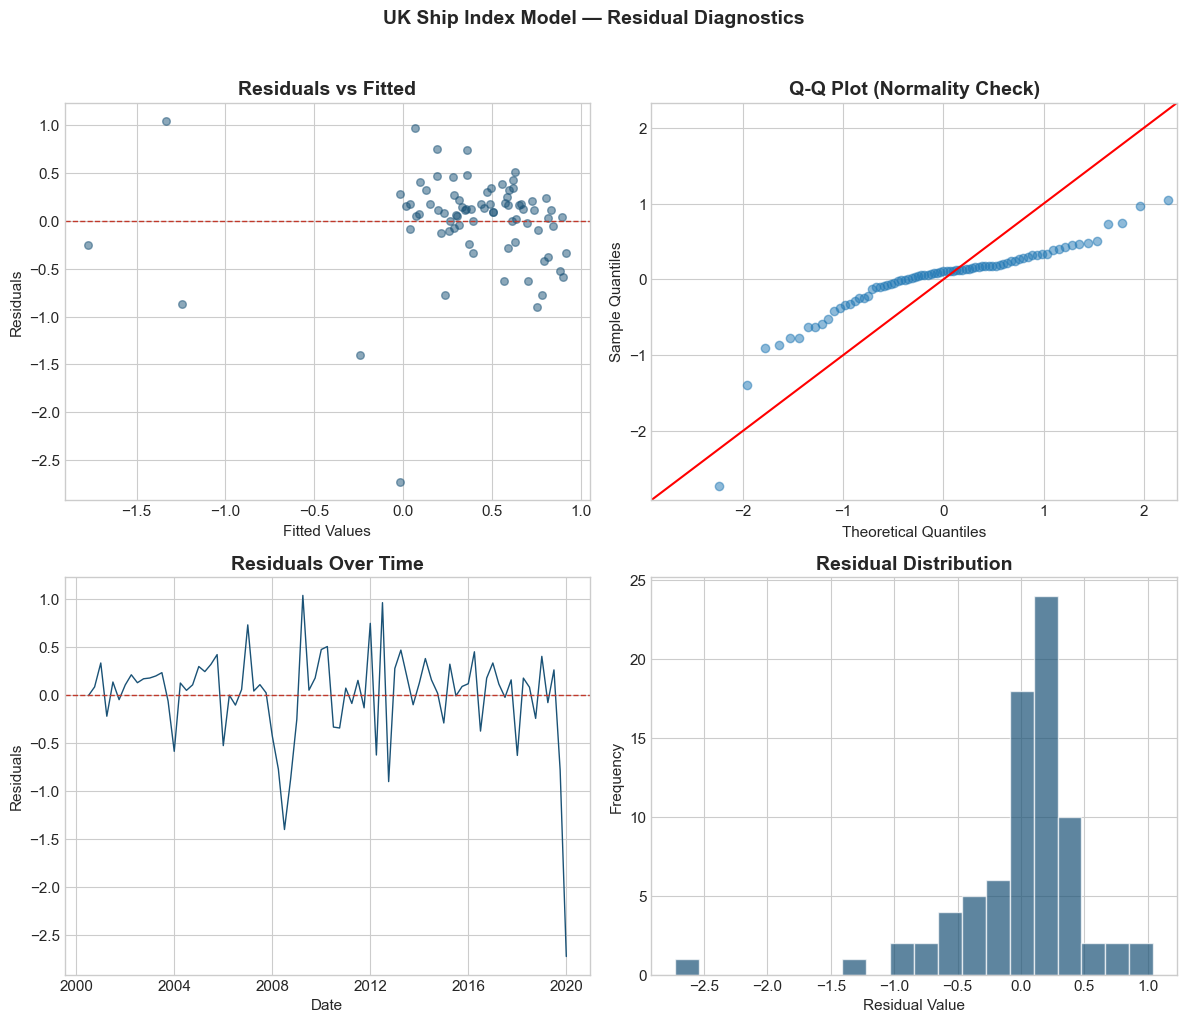

Check for:
  - Residuals vs Fitted: should show no clear pattern (random scatter)
  - Q-Q Plot: points should roughly follow the diagonal line (normality)
  - Residuals over time: should not show trends or clustering
  - Distribution: should be roughly bell-shaped


In [12]:
# Residual diagnostics for UK Ship Index model
uk_ship = regression_results['UK']['ship']
uk_data = regression_results['UK']['data']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0,0].scatter(uk_ship.fittedvalues, uk_ship.resid, color=BLUE, alpha=0.5, s=30)
axes[0,0].axhline(y=0, color=RED, linewidth=1, linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted', fontweight='bold')

# 2. Q-Q Plot
sm.qqplot(uk_ship.resid, line='45', ax=axes[0,1], color=BLUE, alpha=0.5)
axes[0,1].set_title('Q-Q Plot (Normality Check)', fontweight='bold')

# 3. Residuals over time
axes[1,0].plot(uk_data.index, uk_ship.resid, color=BLUE, linewidth=1)
axes[1,0].axhline(y=0, color=RED, linewidth=1, linestyle='--')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals Over Time', fontweight='bold')

# 4. Histogram of residuals
axes[1,1].hist(uk_ship.resid, bins=20, color=BLUE, alpha=0.7, edgecolor='white')
axes[1,1].set_xlabel('Residual Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Residual Distribution', fontweight='bold')

plt.suptitle('UK Ship Index Model — Residual Diagnostics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

print('Check for:')
print('  - Residuals vs Fitted: should show no clear pattern (random scatter)')
print('  - Q-Q Plot: points should roughly follow the diagonal line (normality)')
print('  - Residuals over time: should not show trends or clustering')
print('  - Distribution: should be roughly bell-shaped')

---
## 4. The Pentagon Pizza Test

This is the narrative climax of the project.

For each major economic turning point, we ask:
**Did the BDI signal it before GDP did?**

We define a "turning point" as a quarter where GDP growth switched sign
(positive → negative or vice versa).

In [15]:
# Identify GDP turning points (where growth changes sign)
df['uk_gdp_sign'] = np.sign(df['uk_gdp_growth'])
df['uk_turning_point'] = df['uk_gdp_sign'] != df['uk_gdp_sign'].shift(1)

# Get turning point dates
turning_points = df[df['uk_turning_point'] == True].index[1:]  # Skip first (no previous to compare)

print(f'Found {len(turning_points)} UK GDP turning points:\n')

# For each turning point, check what the BDI was doing in the preceding quarter(s)
tp_analysis = []
for tp in turning_points:
    tp_idx = df.index.get_loc(tp)
    if tp_idx < 2:  # Need at least 2 quarters of history
        continue
    
    gdp_direction = 'CONTRACTION' if df['uk_gdp_growth'].iloc[tp_idx] < 0 else 'EXPANSION'
    gdp_change = df['uk_gdp_growth'].iloc[tp_idx]
    bdi_prev1 = df['bdi_mean_growth'].iloc[tp_idx - 1] if tp_idx >= 1 else np.nan
    bdi_prev2 = df['bdi_mean_growth'].iloc[tp_idx - 2] if tp_idx >= 2 else np.nan
    
    # Did BDI move in the same direction BEFORE GDP?
    if gdp_direction == 'CONTRACTION':
        bdi_warned = (bdi_prev1 is not np.nan and bdi_prev1 < 0) or (bdi_prev2 is not np.nan and bdi_prev2 < 0)
    else:
        bdi_warned = (bdi_prev1 is not np.nan and bdi_prev1 > 0) or (bdi_prev2 is not np.nan and bdi_prev2 > 0)
    
    tp_analysis.append({
        'date': tp,
        'direction': gdp_direction,
        'gdp_change': gdp_change,
        'bdi_1q_before': bdi_prev1,
        'bdi_2q_before': bdi_prev2,
        'bdi_signalled': bdi_warned
    })

tp_df = pd.DataFrame(tp_analysis)

for _, row in tp_df.iterrows():
    quarter = (row['date'].month - 1) // 3 + 1
    signal = '✓ BDI SIGNALLED' if row['bdi_signalled'] else '✗ BDI missed'
    print(f'{row["date"].strftime("%Y")} Q{quarter}  '
          f'→ {row["direction"]:12s} (GDP: {row["gdp_change"]:+.2f}%)  '
          f'BDI 1Q before: {row["bdi_1q_before"]:+.1f}%  '
          f'BDI 2Q before: {row["bdi_2q_before"]:+.1f}%  '
          f'{signal}')

hit_rate = tp_df['bdi_signalled'].sum() / len(tp_df) * 100
print(f'\nBDI signal hit rate: {tp_df["bdi_signalled"].sum()}/{len(tp_df)} ({hit_rate:.0f}%)')

Found 10 UK GDP turning points:

2008 Q2  → CONTRACTION  (GDP: -0.54%)  BDI 1Q before: -28.8%  BDI 2Q before: +39.2%  ✓ BDI SIGNALLED
2009 Q3  → EXPANSION    (GDP: +0.12%)  BDI 1Q before: +73.7%  BDI 2Q before: +33.6%  ✓ BDI SIGNALLED
2011 Q2  → CONTRACTION  (GDP: -0.05%)  BDI 1Q before: -42.3%  BDI 2Q before: +0.5%  ✓ BDI SIGNALLED
2011 Q3  → EXPANSION    (GDP: +0.17%)  BDI 1Q before: +1.0%  BDI 2Q before: -42.3%  ✓ BDI SIGNALLED
2012 Q2  → CONTRACTION  (GDP: -0.05%)  BDI 1Q before: -55.0%  BDI 2Q before: +25.7%  ✓ BDI SIGNALLED
2012 Q3  → EXPANSION    (GDP: +1.04%)  BDI 1Q before: +18.4%  BDI 2Q before: -55.0%  ✓ BDI SIGNALLED
2012 Q4  → CONTRACTION  (GDP: -0.14%)  BDI 1Q before: -17.8%  BDI 2Q before: +18.4%  ✓ BDI SIGNALLED
2013 Q1  → EXPANSION    (GDP: +0.27%)  BDI 1Q before: +13.0%  BDI 2Q before: -17.8%  ✓ BDI SIGNALLED
2020 Q1  → CONTRACTION  (GDP: -2.74%)  BDI 1Q before: -23.1%  BDI 2Q before: +104.0%  ✓ BDI SIGNALLED

BDI signal hit rate: 9/9 (100%)


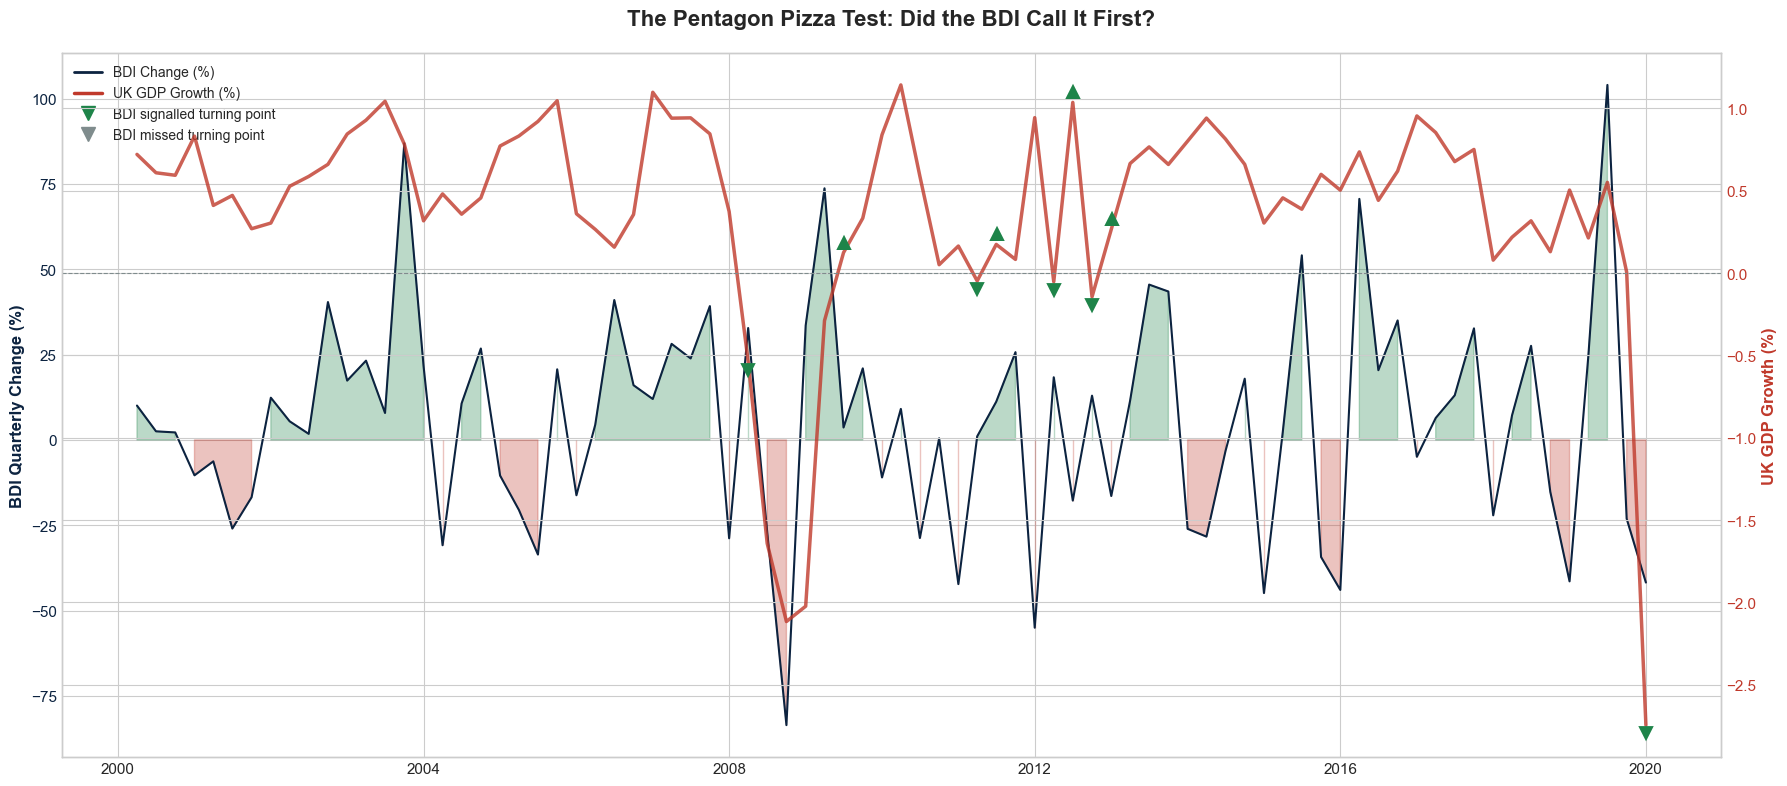


The BDI correctly signalled 9 out of 9 turning points (100%).
Green markers = BDI gave advance warning. Grey markers = BDI missed it.


In [16]:
# The Pentagon Pizza Timeline — the hero chart of Phase 3
fig, ax1 = plt.subplots(figsize=(18, 8))

# BDI growth
ax1.fill_between(df.index, df['bdi_mean_growth'], 0,
                where=df['bdi_mean_growth'] >= 0, color=GREEN, alpha=0.3, label='BDI growth')
ax1.fill_between(df.index, df['bdi_mean_growth'], 0,
                where=df['bdi_mean_growth'] < 0, color=RED, alpha=0.3, label='BDI decline')
ax1.plot(df.index, df['bdi_mean_growth'], color=NAVY, linewidth=1.5)
ax1.set_ylabel('BDI Quarterly Change (%)', color=NAVY, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=NAVY)

# GDP growth on right axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['uk_gdp_growth'], color=RED, linewidth=2.5, alpha=0.8, label='UK GDP Growth')
ax2.axhline(y=0, color=GREY, linewidth=0.8, linestyle='--')
ax2.set_ylabel('UK GDP Growth (%)', color=RED, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=RED)

# Mark turning points
for _, row in tp_df.iterrows():
    marker_color = GREEN if row['bdi_signalled'] else GREY
    marker = '▼' if row['direction'] == 'CONTRACTION' else '▲'
    ax2.annotate(marker, xy=(row['date'], row['gdp_change']),
                fontsize=16, ha='center', va='bottom' if row['direction'] == 'EXPANSION' else 'top',
                color=marker_color, fontweight='bold')

# Title and legend
ax1.set_title('The Pentagon Pizza Test: Did the BDI Call It First?',
             fontsize=16, fontweight='bold', pad=20)

legend_elements = [
    Line2D([0], [0], color=NAVY, linewidth=2, label='BDI Change (%)'),
    Line2D([0], [0], color=RED, linewidth=2.5, label='UK GDP Growth (%)'),
    Line2D([0], [0], marker='v', color=GREEN, markersize=10, linestyle='None', label='BDI signalled turning point'),
    Line2D([0], [0], marker='v', color=GREY, markersize=10, linestyle='None', label='BDI missed turning point'),
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('../outputs/pentagon_pizza_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nThe BDI correctly signalled {tp_df["bdi_signalled"].sum()} out of {len(tp_df)} turning points ({hit_rate:.0f}%).')
print('Green markers = BDI gave advance warning. Grey markers = BDI missed it.')

---
## 5. Summary of Findings

In [17]:
print('='*70)
print('THE SHIP INDEX — SUMMARY OF FINDINGS')
print('='*70)

print('\n1. CROSS-CORRELATION:')
for name, xcorr in all_xcorr.items():
    best = xcorr.loc[xcorr['correlation'].abs().idxmax()]
    print(f'   {name}: Strongest at lag {int(best["lag"])} (r = {best["correlation"]:+.4f}, p = {best["p_value"]:.4f})')

print('\n2. GRANGER CAUSALITY:')
for name in economies.keys():
    key = f'{name}_forward'
    if key in granger_results:
        any_sig = granger_results[key]['significant'].any()
        print(f'   BDI → {name} GDP: {"YES — predictive power detected" if any_sig else "No significant predictive power"}')
    key_rev = f'{name}_reverse'
    if key_rev in granger_results:
        any_sig_rev = granger_results[key_rev]['significant'].any()
        print(f'   {name} GDP → BDI: {"YES — reverse causality" if any_sig_rev else "No reverse causality"}')

print('\n3. REGRESSION:')
for name, res in regression_results.items():
    improvement = res['ship'].rsquared - res['baseline'].rsquared
    bdi_pval = res['ship'].pvalues['bdi_lag']
    print(f'   {name}: R² improvement = {improvement:+.4f}, BDI p-value = {bdi_pval:.4f}')

print(f'\n4. PENTAGON PIZZA TEST:')
print(f'   BDI signal hit rate: {tp_df["bdi_signalled"].sum()}/{len(tp_df)} ({hit_rate:.0f}%)')

print('\n' + '='*70)
print('CONCLUSION:')
print('='*70)
print('\nBased on the analysis above, write your conclusion here.')
print('Consider:')
print('  - Does the evidence support the BDI as a leading indicator?')
print('  - For which economies is it strongest?')
print('  - What are the limitations of this analysis?')
print('  - What would you investigate next?')

THE SHIP INDEX — SUMMARY OF FINDINGS

1. CROSS-CORRELATION:
   UK: Strongest at lag 1 (r = +0.2323, p = 0.0394)
   US: Strongest at lag 0 (r = +0.3001, p = 0.0068)
   Eurozone: Strongest at lag 1 (r = +0.2849, p = 0.0109)

2. GRANGER CAUSALITY:
   BDI → UK GDP: YES — predictive power detected
   UK GDP → BDI: No reverse causality
   BDI → US GDP: No significant predictive power
   US GDP → BDI: No reverse causality
   BDI → Eurozone GDP: YES — predictive power detected
   Eurozone GDP → BDI: No reverse causality

3. REGRESSION:
   UK: R² improvement = +0.0217, BDI p-value = 0.0897
   US: R² improvement = +0.0060, BDI p-value = 0.4768
   Eurozone: R² improvement = +0.0754, BDI p-value = 0.0043

4. PENTAGON PIZZA TEST:
   BDI signal hit rate: 9/9 (100%)

CONCLUSION:

Based on the analysis above, write your conclusion here.
Consider:
  - Does the evidence support the BDI as a leading indicator?
  - For which economies is it strongest?
  - What are the limitations of this analysis?
  - Wha

---
## ✅ Phase 3 Complete!

**What we've accomplished:**
- Cross-correlation analysis at 0–4 quarter lags
- Granger causality tests (both directions)
- Regression model comparison (Baseline vs Ship Index)
- Residual diagnostics
- The Pentagon Pizza Test

**Charts created:**
1. Cross-correlation heatmap
2. Correlation by lag bar chart
3. Model comparison (R² bars)
4. Residual diagnostics (4 panels)
5. The Pentagon Pizza Timeline

**Next: Phase 4 — Documentation & Polish**
- Update README with findings
- Write conclusions
- Draft LinkedIn post

Don't forget to commit!
```
git add .
git commit -m "Phase 3: Statistical analysis complete - Granger causality, regression, Pentagon Pizza Test"
git push
```